# Imports

In [16]:
# Import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
from PyLCM.parameters import *

# Import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# Uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

# JAX
from jax import grad
from jax import random
import jax.numpy as jnp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model initialisation

In [17]:
# SETUP
# Replaces model_init() function

# -model steering parameters
dt = 1. # s
nt = 5 #3600
n_particles = 100 #1000
max_z = 3000. # m
do_condensation = False
do_collision = False
switch_sedi_removal = False # not implemented?

# parcel parameters
T_parcel = 293.2 # K
P_parcel = 101300. # Pa
RH_parcel = 0.88 # -
w_parcel = 1. # ms-1
z_parcel = 0. # m

ascending_mode = "linear" # "sine", "in_cloud_oscillation"
time_half_wave_parcel = 600. # only for "sine", "in_cloud_oscillation" settings
S_lst = 0.

# entrainment parameters
switch_entrainment = False
stability_condition = "Stable" # "Unstable", "Neutral"
entrainment_start = 1000. # s
entrainment_end = 1030. # s
entrainment_rate = 0.05 # ?

# aerosol parameters
kohler_activation_radius = False
switch_kappa_koehler = False
mode_aero_init = "Random" # "Weighting_factor"

# aerosol modes
                # 1         # 2         # 3         # 4
N_aero      = [ 200.e6,     11.00e6,    0.72e6,     0.0e6 ]
mu_aero     = [ 1.e-6,      0.05e-6,    0.46e-6,    0.0e-6 ]
sigma_aero  = [ 3.,         1.60,       2.20,       0.0 ]
k_aero      = [ 1.,         1.6,        1.60,       1.6 ]

# timestep routine
display_mode = "text_fast" # "graphics"

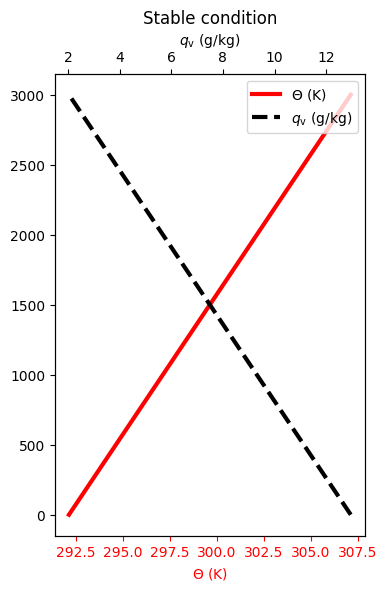

In [18]:
# create environment profile for entrainment

# qv_init same as q_parcel
qv_init = \
    RH_parcel * esatw(T_parcel) / ( P_parcel - RH_parcel * esatw(T_parcel) ) * r_a / rv
q_parcel = qv_init

qv_profiles, theta_profiles, z_env = \
    create_env_profiles(T_parcel, qv_init, z_parcel, P_parcel, stability_condition)

In [19]:
# model init
N_aero, mu_aero, sigma_aero, \
    qa_ts, qc_ts, qr_ts, \
    na_ts, nc_ts, nr_ts, \
    con_ts, act_ts, evp_ts, \
    dea_ts, acc_ts, aut_ts, precip_ts, \
    spectra_arr, \
    T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
    particles_list, particles_array, rc_liq_avg_array, rc_liq_std_array \
        = model_init(
            nt, n_particles,
            T_parcel, P_parcel, z_parcel, q_parcel,
            mode_aero_init, switch_kappa_koehler,
            jnp.array(N_aero), jnp.array(mu_aero), jnp.array(sigma_aero), jnp.array(k_aero)
        )

# JAX setup

In [20]:
key = random.PRNGKey(0)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))

In [21]:
rng = 1.

# Test normal operation

In [22]:
"""
nt, dt, time_array, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, \
spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, \
rc_liq_avg_array, rc_liq_std_array = \
    timesteps_function(
        dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,
        ascending_mode, time_half_wave_parcel,
        switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,
        kohler_activation_radius, switch_kappa_koehler,
        display_mode,
        qv_profiles, theta_profiles,
        rm_spec,
        qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts,
        con_ts, act_ts, evp_ts,
        dea_ts, acc_ts, aut_ts, precip_ts,
        T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array,
        spectra_arr, particles_array, rc_liq_avg_array, rc_liq_std_array,
        particles_list,

        # JAX
        rng # not used in basic mode w/oentrainment, condensation, collision
    )
"""

'\nnt, dt, time_array, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, rc_liq_avg_array, rc_liq_std_array =     timesteps_function(\n        dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,\n        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,\n        ascending_mode, time_half_wave_parcel,\n        switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,\n        kohler_activation_radius, switch_kappa_koehler,\n        display_mode,\n        qv_profiles, theta_profiles,\n        rm_spec,\n        qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts,\n        con_ts, act_ts, evp_ts,\n        dea_ts, acc_ts, aut_ts, precip_ts,\n        T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array,\n        spectra_arr, particles_array, rc_liq_avg_array, rc_liq_std_array,\n        particle

In [23]:
"""
nt, \
dt, \
time_array, \
T_parcel_array, \
RH_parcel_array, \
q_parcel_array, \
z_parcel_array, \
qa_ts, \
qc_ts, \
qr_ts, \
na_ts, \
nc_ts, \
nr_ts, \
con_ts, \
act_ts, \
evp_ts, \
dea_ts, \
acc_ts, \
aut_ts, \
precip_ts, \
rc_liq_avg_array, \
rc_liq_std_array = \
timesteps_function(
    dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,
    T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,
    ascending_mode, time_half_wave_parcel,
    switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,
    kohler_activation_radius, switch_kappa_koehler,
    display_mode,
    jnp.array(qv_profiles), jnp.array(theta_profiles),
    jnp.array(rm_spec),
    jnp.array(qa_ts), jnp.array(qc_ts), jnp.array(qr_ts), jnp.array(na_ts), jnp.array(nc_ts), jnp.array(nr_ts),
    jnp.array(con_ts), jnp.array(act_ts), jnp.array(evp_ts),
    jnp.array(dea_ts), jnp.array(acc_ts), jnp.array(aut_ts), jnp.array(precip_ts),
    jnp.array(T_parcel_array), jnp.array(RH_parcel_array), jnp.array(q_parcel_array), jnp.array(z_parcel_array),
    jnp.array(spectra_arr), jnp.array(particles_array), jnp.array(rc_liq_avg_array), jnp.array(rc_liq_std_array),
    particles_list,

    # JAX
    rng # not used in basic mode w/o entrainment, condensation, collision
)
"""

'\nnt, dt, time_array, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, rc_liq_avg_array, rc_liq_std_array = timesteps_function(\n    dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,\n    T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,\n    ascending_mode, time_half_wave_parcel,\n    switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,\n    kohler_activation_radius, switch_kappa_koehler,\n    display_mode,\n    jnp.array(qv_profiles), jnp.array(theta_profiles),\n    jnp.array(rm_spec),\n    jnp.array(qa_ts), jnp.array(qc_ts), jnp.array(qr_ts), jnp.array(na_ts), jnp.array(nc_ts), jnp.array(nr_ts),\n    jnp.array(con_ts), jnp.array(act_ts), jnp.array(evp_ts),\n    jnp.array(dea_ts), jnp.array(acc_ts), jnp.array(aut_ts), jnp.array(precip_ts),\n    jnp.array(T_parcel_array), jnp.array(RH_parcel_array), jnp.arra

# Auto diff

In [24]:
grad_timesteps_function = grad(
    timesteps_function, 0, allow_int=True
)

In [25]:
result = grad_timesteps_function(
    dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,
    T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,
    ascending_mode, time_half_wave_parcel,
    switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,
    kohler_activation_radius, switch_kappa_koehler,
    display_mode,
    jnp.array(qv_profiles), jnp.array(theta_profiles),
    jnp.array(rm_spec),
    jnp.array(qa_ts), jnp.array(qc_ts), jnp.array(qr_ts), jnp.array(na_ts), jnp.array(nc_ts), jnp.array(nr_ts),
    jnp.array(con_ts), jnp.array(act_ts), jnp.array(evp_ts),
    jnp.array(dea_ts), jnp.array(acc_ts), jnp.array(aut_ts), jnp.array(precip_ts),
    jnp.array(T_parcel_array), jnp.array(RH_parcel_array), jnp.array(q_parcel_array), jnp.array(z_parcel_array),
    jnp.array(spectra_arr), jnp.array(particles_array), jnp.array(rc_liq_avg_array), jnp.array(rc_liq_std_array),
    particles_list,

    # JAX
    rng, # not used in basic mode w/o entrainment, condensation, collision
    True
)

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
5.0, 5.0, 293.15118408203125, 12.950354334428733, 88.21495056152344, 0.2999573051929474, 0.0, 59.28160095214844, 152.4384002685547, 0.0


IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [ ]:
print(result)

0.0


In [ ]:
#theta_profiles
#z_env
test_z_val = 100

In [ ]:
from scipy.interpolate import interp1d
prof_interp = interp1d(z_env, theta_profiles)
prof_interp(test_z_val)

array(292.62051392)

In [ ]:
float( jnp.interp(test_z_val, z_env, theta_profiles) )

292.6205139160156

In [ ]:
tst = jnp.zeros(5)

In [ ]:
tst = tst.at[0].set(jnp.array(2.))

In [ ]:
float(tst[-1])

0.0

In [ ]:
tst.at[0].set(5.)

Array([5., 0., 0., 0., 0.], dtype=float32)

In [ ]:
print(type(tst))

<class 'jaxlib.xla_extension.ArrayImpl'>


In [ ]:
import jax

def test_func(x,y):
    for i in range(0,len(y)):
        #jax.debug.print("{i}",i=i)
        y = y.at[i].set(x*i)
        jax.debug.print("{y}",y=y)
    return y[2]

test_grad = grad(test_func)

x = 10.
y = jax.numpy.zeros(3)

#print(x,y)

test_res = test_grad(x,y)
print(test_res)

[0. 0. 0.]
[ 0. 10.  0.]
[ 0. 10. 20.]
2.0


In [26]:
# from jax import jacfwd, jacrev

# # Isolate the function from the weight matrix to the predictions
# f = lambda W: predict(W, b, inputs)

# J = jacfwd(f)(W)
# print("jacfwd result, with shape", J.shape)
# print(J)

# J = jacrev(f)(W)
# print("jacrev result, with shape", J.shape)
# print(J)

In [27]:
# import jax
# import jax.numpy as np

# def my_function(inputs):
#     # Define a function that computes multiple outputs
#     output1 = inputs[0] ** 2
#     output2 = np.sin(inputs[1])
#     output3 = inputs[0] * inputs[1]
#     return np.array([output1, output2, output3])

# # Example usage:
# inputs = np.array([2.0, 1.0])  # Example input values

# # Use jax.jacfwd to compute the Jacobian matrix
# jacobian_matrix = jax.jacfwd(my_function)(inputs)

# print("Jacobian Matrix:")
# print(jacobian_matrix)